# Develop a CasADi Model of The Steady-State Solar Plant RTO Problem

Replicate the calculations in the Excel spreadsheet implementation and try to solve with CasADi.

- `Solar Plant Optimization of N-Pumps I-O 2025-08-29.xlsm`

In [1]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This data is from the Excel spreadsheet
test_data = {
    "pump_speed_scaled": 0.75346732613277,
    "actual_pump_speed": 2362.913291,
    "pump_dp": 629.0871255,
    "boiler_dp": 592.0326755,
    "total_flow_rate": 124.8190981,
    "pump_fluid_power": 21.81169101,
    "valve_positions": np.array([
        1.000000000, 0.936959219, 0.896931101, 0.865584094, 0.836992607,
        0.812643981, 0.789969825, 0.769361992, 0.93925857, 0.898066194,
        0.864955164, 0.837553205, 0.812789834, 0.789567955, 0.769638106
    ]),
    "loop_dp": 37.05445002,
    "collector_flow_rates": np.array([
        9.176854533, 8.921921744, 8.699651745, 8.486496198, 8.259228335,
        8.039822348, 7.813881615, 7.590786245, 8.933134895, 8.706698355,
        8.481841868, 8.263997082, 8.041208355, 7.809690683, 7.593884098,
    ]),
    "pump_and_drive_efficiency": 0.533426021,
    "pump_and_drive_power": 40.88981445,
    "oil_return_temp": 273,
    "ambient_temp": 20,
    "solar_rate": 900,
    "loop_thermal_efficiencies": np.array([
        0.9, 0.88, 0.86, 0.84, 0.82, 
        0.8, 0.78, 0.76, 0.88, 0.86, 
        0.84, 0.82, 0.8, 0.78, 0.76
    ]),
    "oil_exit_temps": np.array([
        394.7139109242, 395.1327523393, 395.1245265650, 394.9873377920, 395.0471019449,
        394.9932710362, 395.0362115268, 395.0368832622, 394.9823714639, 395.0276211405,
        395.0529329871, 394.9781258321, 394.9726891283, 395.1002726780, 394.9882151924,
    ]),
    "rms_dev": 0.0949969508554
}

assert np.isclose(
    test_data["total_flow_rate"], 
    np.sum(test_data["collector_flow_rates"])
)

## Pump and Flow Calcualtions

In [3]:
# Actual speed range: 1000 - rpm
# Scaled speed range: 0.2 - 1.0
PUMP_SPEED_MIN = 1000
PUMP_SPEED_MAX = 2970

def actual_pump_speed_from_scaled(speed_scaled):
    return PUMP_SPEED_MIN + (speed_scaled - 0.2) * (PUMP_SPEED_MAX - PUMP_SPEED_MIN) / 0.8

# Test calculation
assert actual_pump_speed_from_scaled(0.2) == PUMP_SPEED_MIN
assert actual_pump_speed_from_scaled(1.0) == PUMP_SPEED_MAX

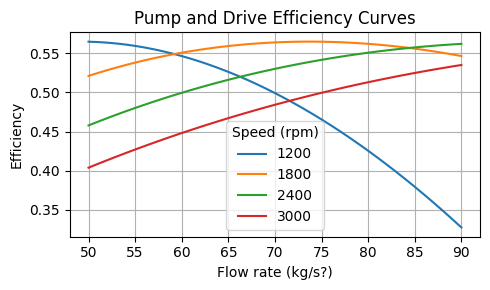

In [4]:
def calculate_pump_and_drive_efficiency(total_flow_rate, actual_pump_speed):
    # Excel formula BI36: =($AD$23/$C$7)*(48.91052-123.18953*($AD$23/$C$7)^0.392747)
    x = total_flow_rate / actual_pump_speed
    return x * (48.91052 - 123.18953 * x ** 0.392747)

flow_rates = np.linspace(50, 90, 41)

plt.figure(figsize=(5, 3))
for pump_speed in [1200, 1800, 2400, 3000]:
    pump_and_drive_efficiency = calculate_pump_and_drive_efficiency(
        flow_rates, pump_speed
    )
    plt.plot(flow_rates, pump_and_drive_efficiency, label=pump_speed)
plt.xlabel('Flow rate (kg/s?)')
plt.ylabel('Efficiency')
plt.grid()
plt.legend(title="Speed (rpm)")
plt.title("Pump and Drive Efficiency Curves")
plt.tight_layout()
plt.show()

In [5]:
def calculate_pump_fluid_power(total_flow_rate, loop_dp):
    return (total_flow_rate / 3600) * loop_dp

# Test calculation
pump_dp = test_data["pump_dp"]
total_flow_rate = test_data["total_flow_rate"]
pump_fluid_power = calculate_pump_fluid_power(total_flow_rate, pump_dp)
assert np.isclose(pump_fluid_power, test_data["pump_fluid_power"])

In [6]:
def calculate_collector_flow_rate(
    valve_position, loop_dp, rangeability=50, b=0.04, c=0.4, sqrt=cas.sqrt
):
    # Excel formula AD8: =D8*SQRT(($AC$23)/($F$4+$F$5*D8^2))
    f = rangeability ** (valve_position - 1.0)
    return f * sqrt(loop_dp / (b + c * f ** 2))

# Test calculation
valve_position = test_data["valve_positions"][1]
loop_dp = test_data["loop_dp"]
collector_flow_rate = calculate_collector_flow_rate(valve_position, loop_dp)
assert np.isclose(collector_flow_rate, test_data["collector_flow_rates"][1])

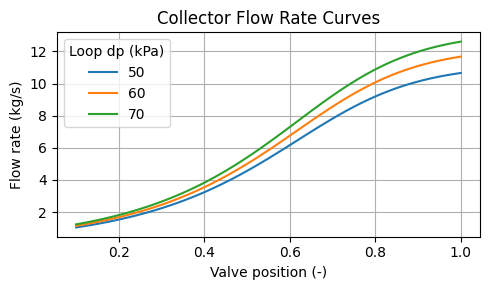

In [7]:
valve_positions = np.linspace(0.1, 1.0, 91)

plt.figure(figsize=(5, 3))
for loop_dp in [50, 60, 70]:
    flow_rate = calculate_collector_flow_rate(valve_positions, loop_dp)
    plt.plot(valve_positions, flow_rate, label=loop_dp)
plt.xlabel('Valve position (-)')
plt.ylabel('Flow rate (kg/s)')
plt.grid()
plt.legend(title="Loop dp (kPa)")
plt.title("Collector Flow Rate Curves")
plt.tight_layout()
plt.show()

In [8]:
def calculate_total_flowrate(
    valve_positions, loop_dp, sum=cas.sum, sqrt=cas.sqrt
):
    flow_rates = calculate_collector_flow_rate(
        valve_positions, loop_dp, sqrt=sqrt
    )
    return sum(flow_rates)

# Test calculation
valve_positions = test_data["valve_positions"]
loop_dp = test_data["loop_dp"]
total_flowrate = calculate_total_flowrate(valve_positions, loop_dp)
print(total_flowrate, test_data["total_flow_rate"])
assert np.isclose(total_flowrate, test_data["total_flow_rate"])

124.819 124.8190981


In [9]:
BOILER_FLOW_LOSS_FACTOR = 0.038

def calculate_boiler_dp(total_flow_rate):
    # Excel formula G19: =$H$4*F23^2
    return BOILER_FLOW_LOSS_FACTOR * total_flow_rate ** 2

# Test calculation
total_flow_rate = 124.8296578
boiler_dp = calculate_boiler_dp(total_flow_rate)
assert np.isclose(boiler_dp, 592.132852)

In [10]:
PUMP_DP_MAX = 1004.2368
PUMP_QMAX = 224.6293
EXPONENT = 4.346734

def calculate_pump_dp(actual_pump_speed, total_flow_rate, m_pumps):
    # Excel formula G21: =$C$3*(($C$7/$C$5)^2)*(1-(F23*$C$5/($F$1*$C$4*$C$7))^$C$6)
    return (
        PUMP_DP_MAX * ((actual_pump_speed / PUMP_SPEED_MAX) ** 2) 
        * (
            1 - (
                total_flow_rate * PUMP_SPEED_MAX 
                / (m_pumps * PUMP_QMAX * actual_pump_speed)
            ) ** EXPONENT
        )
    )

# Test calculation
actual_pump_speed = 2362.776896
m_pumps = 2
pump_dp = calculate_pump_dp(actual_pump_speed, total_flow_rate, m_pumps)
assert np.isclose(pump_dp, 629.0104406)

In [11]:
def calculate_pressure_balance(loop_dp, pump_dp, boiler_dp):
    # AE23: =AC23-(AE21-AE19)
    return loop_dp - (pump_dp - boiler_dp)

# Test calculation
loop_dp = 36.8775886
pump_dp = 629.0104406
boiler_dp = 592.132852
pressure_balance = calculate_pressure_balance(loop_dp, pump_dp, boiler_dp)

assert np.isclose(pressure_balance, 0.0)

In [12]:
def calculate_total_flowrate(
    valve_positions, loop_dp, sum=cas.sum, sqrt=cas.sqrt
):
    flow_rates = calculate_collector_flow_rate(
        valve_positions, loop_dp, sqrt=sqrt
    )
    return sum(flow_rates)

# Test calculation
valve_positions = test_data["valve_positions"]
loop_dp = test_data["loop_dp"]
total_flow_rate = calculate_total_flowrate(valve_positions, loop_dp)
assert np.isclose(total_flow_rate, test_data["total_flow_rate"])

pump_speed_scaled = test_data["pump_speed_scaled"]
actual_pump_speed = actual_pump_speed_from_scaled(pump_speed_scaled)
assert np.isclose(actual_pump_speed, test_data["actual_pump_speed"])

pump_dp = test_data["pump_dp"]
pump_fluid_power = calculate_pump_fluid_power(total_flow_rate, pump_dp)
assert np.isclose(pump_fluid_power, test_data["pump_fluid_power"])

m_pumps = 2
pump_and_drive_efficiency = calculate_pump_and_drive_efficiency(
    total_flow_rate, actual_pump_speed
)
assert np.isclose(pump_and_drive_efficiency, test_data["pump_and_drive_efficiency"])

pump_and_drive_power = pump_fluid_power / pump_and_drive_efficiency
assert np.isclose(pump_and_drive_power, test_data["pump_and_drive_power"])

In [13]:
def make_pressure_balance_function(n_lines, m_pumps, sum=cas.sum, sqrt=cas.sqrt):

    valve_positions = cas.SX.sym('v', n_lines)
    pump_speed_scaled = cas.SX.sym('s')
    loop_dp = cas.SX.sym('dp')

    actual_pump_speed = actual_pump_speed_from_scaled(pump_speed_scaled)

    total_flow_rate = calculate_total_flowrate(
        valve_positions, loop_dp, sum=sum, sqrt=sqrt
    )

    boiler_dp = calculate_boiler_dp(total_flow_rate)

    pump_dp = calculate_pump_dp(actual_pump_speed, total_flow_rate, m_pumps)

    pressure_balance = calculate_pressure_balance(loop_dp, pump_dp, boiler_dp)

    return cas.Function(
        "pressure_balance", 
        [valve_positions, pump_speed_scaled, loop_dp], 
        [pressure_balance], 
        ["valve_positions", "pump_speed_scaled", "loop_dp"], 
        ["pressure_balance"]
    )



def make_system_equations():
    

    pump_and_drive_efficiency = \
        calculate_pump_and_drive_efficiency(
            total_flow_rate, actual_pump_speed
        )

    pump_and_drive_power = pump_fluid_power / pump_and_drive_efficiency


n_lines = 15
m_pumps = 2
pressure_balance_function = make_pressure_balance_function(n_lines, m_pumps)
pressure_balance_function

Function(pressure_balance:(valve_positions[15],pump_speed_scaled,loop_dp)->(pressure_balance) SXFunction)

In [14]:
# Test calculation
valve_positions = test_data["valve_positions"]
pump_speed_scaled = test_data["pump_speed_scaled"]
loop_dp = test_data["loop_dp"]

pressure_balance = pressure_balance_function(
    valve_positions, pump_speed_scaled, loop_dp
)
assert np.isclose(pressure_balance, [[0.0]], atol=1e-5)

## Use Rootfinder to Find Pressure Balance

In [15]:
def g(x):
    loop_dp = x
    return pressure_balance_function(
        cas.DM(valve_positions), cas.DM(pump_speed_scaled), loop_dp
    )

x = cas.SX.sym('x')
rf = cas.rootfinder('rf', 'newton', {'x': x, 'g': g(x)})

x_sol_rf = rf([30.0], [])
x_sol_rf

DM(37.0545)

In [16]:
# Turn the solution of the root-finder solution into a function

def make_calculate_pump_and_drive_power_function(
    n_lines, m_pumps, sum=cas.sum, sqrt=cas.sqrt
):

    valve_positions = cas.SX.sym('v', n_lines)
    pump_speed_scaled = cas.SX.sym('s')

    pressure_balance_function = make_pressure_balance_function(
        n_lines, m_pumps, sum=sum, sqrt=sqrt
    )
    
    # Make rootfinder to solve pressure balance
    x = cas.SX.sym('x')
    p = cas.vertcat(valve_positions, pump_speed_scaled)
    residual = pressure_balance_function(valve_positions, pump_speed_scaled, x)
    rf = cas.rootfinder('RF', 'newton', {'x': x, 'p': p, 'g': residual})

    # Root finder solution
    sol_rf = rf(x0=[30.0], p=p)
    loop_dp = sol_rf['x']

    flow_rates = calculate_collector_flow_rate(
        valve_positions, loop_dp, sqrt=sqrt
    )

    total_flow_rate = sum(flow_rates)

    actual_pump_speed = actual_pump_speed_from_scaled(pump_speed_scaled)

    pump_and_drive_efficiency = calculate_pump_and_drive_efficiency(
        total_flow_rate, actual_pump_speed
    )

    pump_dp = calculate_pump_dp(actual_pump_speed, total_flow_rate, m_pumps)

    pump_fluid_power = calculate_pump_fluid_power(total_flow_rate, pump_dp)

    pump_and_drive_power = pump_fluid_power / pump_and_drive_efficiency

    return cas.Function(
        "calculate_pump_and_drive_power", 
        [valve_positions, pump_speed_scaled], 
        [pump_and_drive_power],
        ["valve_positions", "pump_speed_scaled"], 
        ["pump_and_drive_power"]
    )

pump_and_drive_power_function = \
    make_calculate_pump_and_drive_power_function(n_lines, m_pumps)
pump_and_drive_power_function

Function(calculate_pump_and_drive_power:(valve_positions[15],pump_speed_scaled)->(pump_and_drive_power) SXFunction)

In [17]:
# Test calculation
valve_positions = test_data["valve_positions"]
pump_speed_scaled = test_data["pump_speed_scaled"]
pump_and_drive_power_function(valve_positions, pump_speed_scaled)
assert np.isclose(pump_and_drive_power, test_data["pump_and_drive_power"])

In [18]:
%timeit pump_and_drive_power_function(valve_positions, pump_speed_scaled)

35.8 μs ± 735 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Oil Exit Temperature Calculations

In [19]:
LOOP_THERMAL_EFFICIENCIES = [
    0.9, 0.88, 0.86, 0.84, 0.82, 0.8, 0.78, 0.76,
    0.88, 0.86, 0.84, 0.82, 0.8, 0.78, 0.76
]

In [20]:
OIL_RHO = 800  # Kg/m^3
OIL_RHO_CP = 1600
HO = 0.00361
D_OUT = 0.07  # m


def calculate_collector_oil_exit_temp(
    flow_rate, 
    oil_return_temp, 
    ambient_temp, 
    solar_rate, 
    loop_thermal_efficiency, 
    exp=cas.exp, 
    pi=cas.pi
):
    # a AR8: =($AH$3*50/1000)*AH8/3.14159/$AH$5+$AH$2
    # b AS8: =$AH$1-AR8
    # tau AT8: =(AD8/3600)*$AO$4/3.14159/$AH$5/$CX$7
    # AI8: =AR8+AS8*EXP(-192/AT8)
    a = (solar_rate * 50 / 1000) * loop_thermal_efficiency / pi / HO + ambient_temp
    b = oil_return_temp - a
    tau = (flow_rate / 3600) * OIL_RHO_CP / pi / HO / D_OUT
    return a + b * exp(-192 / tau)


# Test calculation
flow_rate = 8.968468201
oil_return_temp = 273
ambient_temp = 20
solar_rate = 900
loop_thermal_efficiency = 0.9
oil_exit_temp = calculate_collector_oil_exit_temp(
    flow_rate, 
    oil_return_temp, 
    ambient_temp, 
    solar_rate, 
    loop_thermal_efficiency
)
assert np.isclose(oil_exit_temp, 397.4882567363479)

# Test calculation - vectorized
collector_flow_rates = cas.DM(test_data["collector_flow_rates"])
oil_return_temp = test_data["oil_return_temp"]
ambient_temp = test_data["ambient_temp"]
solar_rate = test_data["solar_rate"]
loop_thermal_efficiencies = cas.DM(test_data["loop_thermal_efficiencies"])
oil_exit_temps = calculate_collector_oil_exit_temp(
    collector_flow_rates,
    oil_return_temp,
    ambient_temp,
    solar_rate,
    loop_thermal_efficiencies
)
assert np.allclose(
    oil_exit_temps,
    test_data["oil_exit_temps"].reshape(-1, 1)
)

In [21]:
OIL_EXIT_TEMPS_SP = [
    395.0, 395.0, 395.0, 395.0, 395.0,
    395.0, 395.0, 395.0, 395.0, 395.0,
    395.0, 395.0, 395.0, 395.0, 395.0,
]

def calculate_rms_oil_exit_temps(oil_exit_temps, oil_exit_temps_sp, sqrt=cas.sqrt, sumsqr=cas.sumsqr):
    N = oil_exit_temps.shape[0]
    return sqrt(sumsqr(oil_exit_temps_sp - oil_exit_temps) / N)

rms_dev = calculate_rms_oil_exit_temps(oil_exit_temps, cas.DM(OIL_EXIT_TEMPS_SP))
assert np.isclose(rms_dev, test_data["rms_dev"], atol=0.00001)

## Combine into Collector and Pumps System Model

In [22]:
def make_collector_exit_temps_and_pump_power_function(
    n_lines, m_pumps, sum=cas.sum, sqrt=cas.sqrt, exp=cas.exp, pi=cas.pi
):

    valve_positions = cas.SX.sym('v', n_lines)
    pump_speed_scaled = cas.SX.sym('pump_speed_scaled')
    oil_return_temp = cas.SX.sym('oil_return_temp')
    ambient_temp = cas.SX.sym('ambient_temp')
    solar_rate = cas.SX.sym('solar_rate')

    pressure_balance_function = make_pressure_balance_function(
        n_lines, m_pumps, sum=sum, sqrt=sqrt
    )

    def g(x):
        loop_dp = x
        return pressure_balance_function(
            valve_positions, pump_speed_scaled, loop_dp
        )

    # Make rootfinder to solve pressure balance
    x = cas.SX.sym('x')
    p = cas.vertcat(valve_positions, pump_speed_scaled)
    residual = pressure_balance_function(valve_positions, pump_speed_scaled, x)
    rf = cas.rootfinder('RF', 'newton', {'x': x, 'p': p, 'g': residual})

    # Root finder solution
    sol_rf = rf(x0=[30.0], p=p)
    loop_dp = sol_rf['x']

    flow_rates = calculate_collector_flow_rate(
        valve_positions, loop_dp, sqrt=sqrt
    )

    total_flow_rate = sum(flow_rates)

    actual_pump_speed = actual_pump_speed_from_scaled(pump_speed_scaled)

    pump_and_drive_efficiency = calculate_pump_and_drive_efficiency(
        total_flow_rate, actual_pump_speed
    )

    pump_dp = calculate_pump_dp(actual_pump_speed, total_flow_rate, m_pumps)

    pump_fluid_power = calculate_pump_fluid_power(total_flow_rate, pump_dp)

    pump_and_drive_power = pump_fluid_power / pump_and_drive_efficiency

    oil_exit_temps = calculate_collector_oil_exit_temp(
        flow_rates,
        oil_return_temp,
        ambient_temp,
        solar_rate,
        LOOP_THERMAL_EFFICIENCIES,
        exp=exp,
        pi=pi
    )

    return cas.Function(
        "calculate_collector_exit_temps_and_pump_power", 
        [valve_positions, pump_speed_scaled, oil_return_temp, ambient_temp, solar_rate], 
        [total_flow_rate, pump_and_drive_power, oil_exit_temps],
        ["valve_positions", "pump_speed_scaled", "oil_return_temp", "ambient_temp", "solar_rate"], 
        ["total_flow_rate", "pump_and_drive_power", "oil_exit_temps"],
    )

calculate_exit_temps_and_pump_power = \
    make_collector_exit_temps_and_pump_power_function(n_lines, m_pumps)

calculate_exit_temps_and_pump_power

Function(calculate_collector_exit_temps_and_pump_power:(valve_positions[15],pump_speed_scaled,oil_return_temp,ambient_temp,solar_rate)->(total_flow_rate,pump_and_drive_power,oil_exit_temps[15]) SXFunction)

In [23]:
# Test calculation
valve_positions = test_data["valve_positions"]
pump_speed_scaled = test_data["pump_speed_scaled"]
oil_return_temp = test_data["oil_return_temp"]
ambient_temp = test_data["ambient_temp"]
solar_rate = test_data["solar_rate"]

total_flow_rate, pump_and_drive_power, oil_exit_temps = calculate_exit_temps_and_pump_power(
    valve_positions, pump_speed_scaled, oil_return_temp, ambient_temp, solar_rate
)
assert np.allclose(
    oil_exit_temps,
    test_data["oil_exit_temps"].reshape(-1, 1)
)

In [24]:
%%time

total_flow_rate, pump_and_drive_power, oil_exit_temps = calculate_exit_temps_and_pump_power(
    valve_positions, pump_speed_scaled, oil_return_temp, ambient_temp, solar_rate
)

CPU times: total: 0 ns
Wall time: 0 ns


## Setup Optimization Problem

In [25]:
opti = cas.Opti()

# Problem dimensions
n_lines = 15
m_pumps = 3

# Construct system model calculation function
calculate_exit_temps_and_pump_power = \
    make_collector_exit_temps_and_pump_power_function(n_lines, m_pumps)

# Parameters
oil_return_temp = 273
ambient_temp = 20
solar_rate = 900
oil_exit_temps_sp = cas.DM(OIL_EXIT_TEMPS_SP)
EC1 = 1.0
EC2 = 20.0
line_1_valve_pos = 1.0

# Decision variables
valve_2_to_n_positions = opti.variable(n_lines - 1)
pump_speed_scaled = opti.variable()

valve_positions = cas.vertcat(line_1_valve_pos, valve_2_to_n_positions)

# Add constraints
opti.subject_to(opti.bounded(0.5, valve_2_to_n_positions, 1.0))  # TODO: Lifted constraint
opti.subject_to(opti.bounded(0.5, pump_speed_scaled, 1.0))

# System model outputs
total_flow_rate, pump_and_drive_power, oil_exit_temps = calculate_exit_temps_and_pump_power(
    valve_positions, pump_speed_scaled, oil_return_temp, ambient_temp, solar_rate
)
assert pump_and_drive_power.shape == (1, 1)
assert oil_exit_temps.shape == (n_lines, 1)

rms_dev = calculate_rms_oil_exit_temps(oil_exit_temps, oil_exit_temps_sp)
assert rms_dev.shape == (1, 1)

# Cost function
cost = rms_dev / EC1 + pump_and_drive_power / EC2
assert cost.shape == (1, 1)
opti.minimize(cost)

# Set initial values
opti.set_initial(valve_2_to_n_positions, 0.95)
opti.set_initial(pump_speed_scaled, 0.8)

opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 15)
  #parameters: 0 (np = 0)
  #constraints: 2 (ng = 15)
  CasADi solver needs updating.
})

In [26]:
opti.solver('ipopt')
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       15
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1338: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Error_In_Step_Computation'

In [27]:
opti.debug.value(cost)

2.049093346073562

In [28]:
rms_dev_sol = opti.value(rms_dev)
pump_speed_scaled_sol = opti.value(pump_speed_scaled)
pump_and_drive_power_sol = opti.value(pump_and_drive_power)
valve_positions_sol = opti.value(valve_positions)
oil_exit_temps_sol = opti.value(oil_exit_temps)

print(f"rms_dev_sol: {rms_dev_sol:.5f}")
print(f"pump_speed_scaled: {pump_speed_scaled_sol:.5f}")
print(f"pump_and_drive_power: {pump_and_drive_power_sol:.3f} kW")

print("\nValve settings")
print(f"   {'Valve':7s} {'Oil T':7s}")
for i, (x, T) in enumerate(zip(valve_positions_sol, oil_exit_temps_sol), start=1):
    print(f"{i:2d} {x:7.5f} {T:7.3f}")

rms_dev_sol: 0.00000
pump_speed_scaled: 0.74931
pump_and_drive_power: 40.982 kW

Valve settings
   Valve   Oil T  
 1 1.00000 395.000
 2 0.94346 395.000
 3 0.90180 395.000
 4 0.86823 395.000
 5 0.83972 395.000
 6 0.81463 395.000
 7 0.79200 395.000
 8 0.77120 395.000
 9 0.94346 395.000
10 0.90180 395.000
11 0.86823 395.000
12 0.83972 395.000
13 0.81463 395.000
14 0.79200 395.000
15 0.77120 395.000


In [29]:
# To transfer values to Excel
# print(", ".join(f"{x:.8f}" for x in valve_positions_sol))

## Steam Generator Model

In [30]:
# TODO: Not complete

def calculate_steam_power():
    # =BG31*(3049-2207)
    pass

In [31]:
GENERATOR_EFFICIENCY = 0.85

def calculate_net_power(steam_power, pump_fluid_power, pump_and_drive_efficiency):
    # BI37: =BI33*BI34-BI35/BI36
    return steam_power * GENERATOR_EFFICIENCY - pump_fluid_power / pump_and_drive_efficiency

steam_power = 1639.813211
pump_fluid_power = 21.81087724
pump_and_drive_efficiency = 0.533387324
net_power = calculate_net_power(steam_power, pump_fluid_power, pump_and_drive_efficiency)
assert np.isclose(net_power, 1352.949974049002)